In [1]:
# For data generation
import sys
# !{sys.executable} -m pip install matplotlib --upgrade
import shutil
import os
import numpy as np
from glob import glob
import re
import pandas as pd
import pickle
#random
from time import perf_counter

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import GridSearchCV


#Plotting
import seaborn as sns
sns.set_style()
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 200

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 


from tqdm.auto import tqdm
# from tqdm.notebook import tqdm_notebook as tqdm

In [2]:
with open('test_ind.pickle', 'rb') as handle:
    test_ind = pickle.load(handle)

with open('train_ind.pickle', 'rb') as handle:
    train_ind = pickle.load(handle)
    
print(len(train_ind),len(test_ind))    


50 50


In [3]:
# feat_name=['From_Same_Orbital', 'pair_energy', 'coulomb', 'screen1_1', 'screen1_2',
#        'screen1_3', 'screen1_4', 'screen2_1', 'screen2_2', 'screen2_3',
#        'screen2_4', 'eijab_1', 'eijab_2', 'eijab_3', 'eijab_4', 'screenvirt_1',
#        'screenvirt_2', 'screenvirt_3', 'screenvirt_4', 'Fr1', 'Fr2', 'Fr3',
#        'Fr4', 'Fs1', 'Fs2', 'Fs3', 'Fs4', 'occr1', 'occr2', 'occr3', 'occr4',
#        'occs1', 'occs2', 'occs3', 'occs4', 'SCFFr1', 'SCFFr2', 'SCFFr3',
#        'SCFFr4', 'SCFFs1', 'SCFFs2', 'SCFFs3', 'SCFFs4', 'SCFOCCr1',
#        'SCFOCCr2', 'SCFOCCr3', 'SCFOCCr4', 'SCFOCCs1', 'SCFOCCs2', 'SCFOCCs3',
#        'SCFOCCs4', 'hrr1', 'hrr2', 'hrr3', 'hrr4', 'hss1', 'hss2', 'hss3',
#        'hss4', 'hpp', 'hqq', 'Fp', 'Fq', 'occp', 'occq', 'SCFFp', 'SCFFq',
#        'SCFOCCp', 'SCFOCCq']

feat_name=['coulomb', 'screen1_1', 'screen1_2', 'screen1_3', 'screen1_4', 'screen2_1', 'screen2_2', 'screen2_3', 'screen2_4', 'screenvirt_1', 'screenvirt_2', 'screenvirt_3', 'screenvirt_4', 'SCFFr1', 'SCFFr2', 'SCFFr3', 'SCFFr4', 'SCFFs1', 'SCFFs2', 'SCFFs3', 'SCFFs4', 'SCFOCCr1', 'SCFOCCr2', 'SCFOCCr3', 'SCFOCCr4', 'SCFOCCs1', 'SCFOCCs2', 'SCFOCCs3', 'SCFOCCs4', 'hrr1', 'hrr2', 'hrr3', 'hrr4', 'hss1', 'hss2', 'hss3', 'hss4', 'hpp', 'hqq', 'SCFFp', 'SCFFq', 'SCFOCCp', 'SCFOCCq']


In [4]:
train_X=[]
train_y = []

test_X=[]
test_y = []
# for nam in sorted(glob('*/fixed_feats.pickle'),key=lambda x: int(x.split('_')[0].strip('H')))[2:]:
for nam in glob('*/fixed_feats.pickle'):
    trydf=pd.read_pickle(nam).astype(float)[feat_name]    
    Hnam=nam.split('/')[0].split('_')[0]
    for i in train_ind:
        train_X.append(trydf.loc[f'{Hnam}_chain/{Hnam}_{i:.2f}'].values)
    for j in test_ind: 
        test_X.append(trydf.loc[f'{Hnam}_chain/{Hnam}_{j:.2f}'].values)
    
    
# This recover is wrong... did not account for the # of pair-energies     
recover_train=[]    
recover_test=[]    
tst_idx=0
tr_idx=0
for nidx,nam in enumerate(glob('*/fixed_targets.pickle')):
    trydf=pd.read_pickle(nam).astype(float)
    Hnam=nam.split('/')[0].split('_')[0]
    for tridx,i in enumerate(train_ind):
        pairdf=trydf[f'{i:.2f}'].values
        train_y.append(pairdf)
        for k in range(len(pairdf)):
            recover_train.append((nam.split('_')[0],tridx,tr_idx))
            tr_idx+=1
        
    for teidx,j in enumerate(test_ind): 
        pairdf=trydf[f'{j:.2f}'].values
        test_y.append(pairdf)        
        
        for k in range(len(pairdf)):
            recover_test.append((nam.split('_')[0],teidx,tst_idx))
            tst_idx+=1


In [5]:
X_train, X_test=np.vstack(train_X).astype(float),np.vstack(test_X).astype(float)
for u,v in np.argwhere(np.isnan(X_train)):
    X_train[u,v]=0
    
for u,v in np.argwhere(np.isnan(X_test)):
    X_test[u,v]=0    

In [6]:
y_train,y_test=np.hstack(train_y).astype(float),np.hstack(test_y).astype(float)

In [7]:
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [8]:
print(X_train.shape,X_test.shape)

(18200, 43) (18200, 43)


In [9]:
from xgboost import XGBRegressor
# model=XGBRegressor(reg_lambda=0.3,max_depth=100,min_child_weight=5)
model=XGBRegressor(max_depth=100,min_child_weight=1,n_estimators=100, reg_alpha=0.001, reg_lambda=0.001)
model.fit(X_train,y_train)
y_pred_train=model.predict(X_train)
y_pred_test=model.predict(X_test)
print(f"R2: {r2_score(y_train,y_pred_train):.4f},{r2_score(y_test,y_pred_test):.4f}")
print(f"RMSE (mEh): {mean_squared_error(y_train,y_pred_train,squared=False)*1e3:.4f},{mean_squared_error(y_test,y_pred_test,squared=False)*1e3:.4f}")

# params = {'max_depth': [1, 10, 100],
# #           'n_estimators': [100, 500, 1000],
#           'reg_lambda': [1e-6, 1e-3,1e-1],
#           'reg_alpha': [1e-6, 1e-3,1e-1]}

# model = XGBRegressor()
# grid = GridSearchCV(estimator=model, 
#                    param_grid=params,
#                    scoring='r2', 
#                    verbose=1000,n_jobs=12).fit(X_train,y_train)


# gmodel=grid.best_estimator_
# y_pred_train=gmodel.predict(X_train)
# y_pred_test=gmodel.predict(X_test)
# print(f"R2: {r2_score(y_train,y_pred_train):.4f},{r2_score(y_test,y_pred_test):.4f}")
# print(f"RMSE (mEh): {mean_squared_error(y_train,y_pred_train,squared=False)*1e3:.4f},{mean_squared_error(y_test,y_pred_test,squared=False)*1e3:.4f}")



R2: 0.9486,0.9230
RMSE (mEh): 0.2421,0.2916


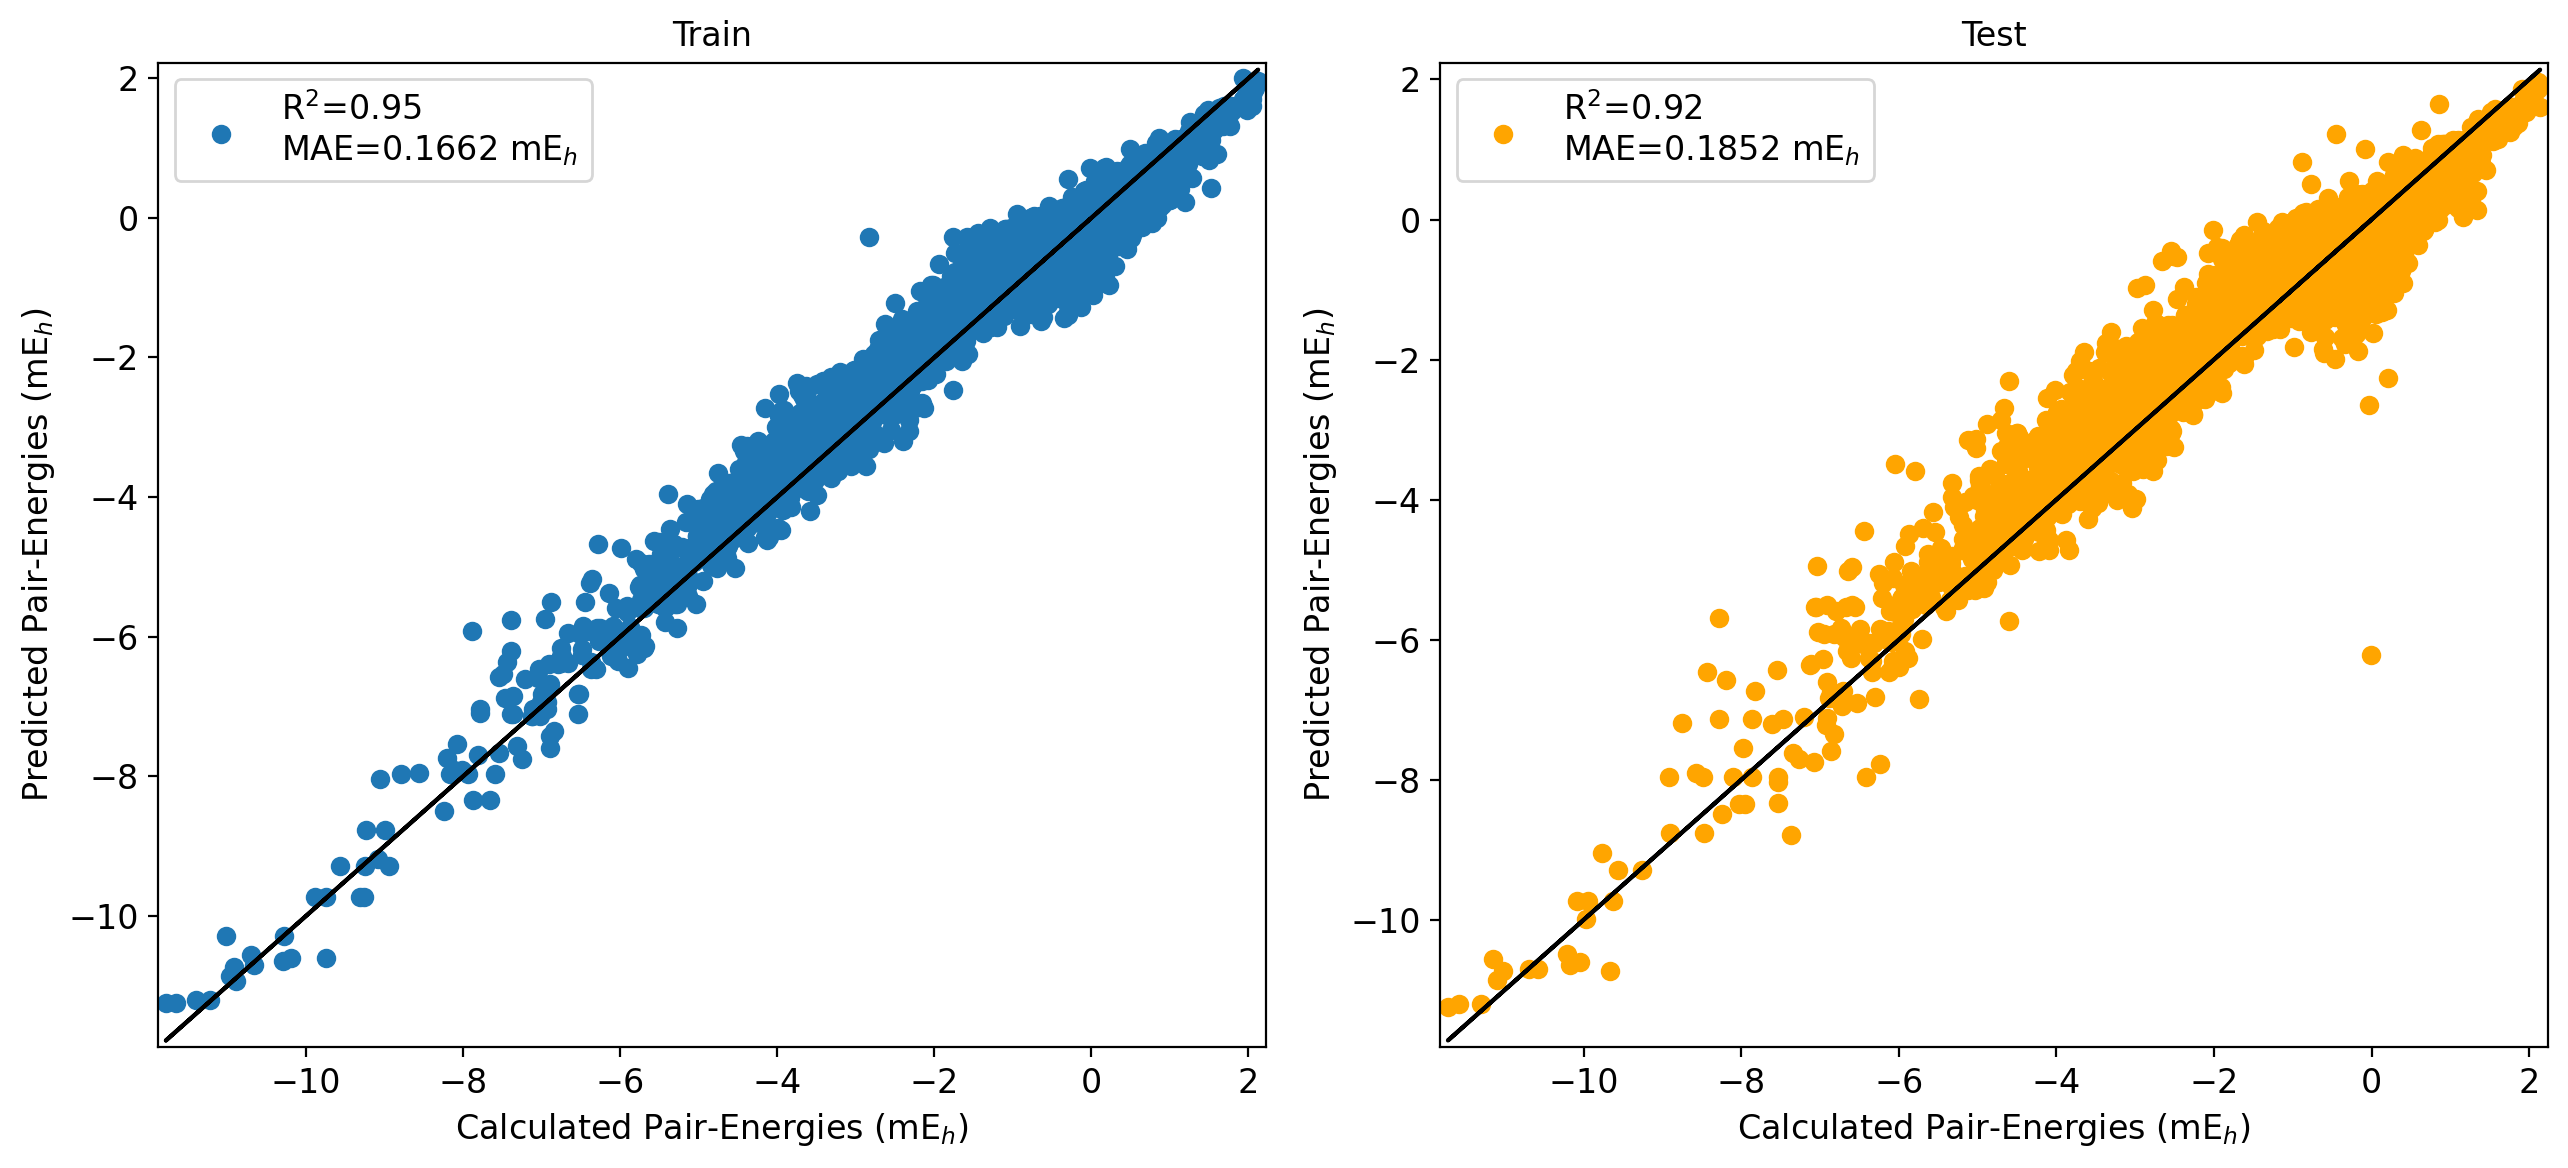

In [10]:
font=12
plt.rc('font', size=font)          # controls default text sizes
plt.rc('axes', titlesize=font)     # fontsize of the axes title
plt.rc('axes', labelsize=font)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=font)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font)    # fontsize of the tick labels
plt.rc('legend', fontsize=font)    # legend fontsize
plt.rc('figure', titlesize=font)  # fontsize of the figure title
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(13,6))
scale=1e-1
ax1.set_title('Train')
ax1.scatter(1e3*y_train,1e3*y_pred_train,label="R$^{2}$="+f'{r2_score(y_train,y_pred_train):.2f}\nMAE={1e3*mean_absolute_error(y_train,y_pred_train):.4f}'+" mE$_{h}$")
ax1.plot(1e3*y_train,1e3*y_train,'k-')
ax1.set_xlim(1e3*min(y_train)-scale,1e3*max(y_train)+scale)
ax1.set_ylim(1e3*min(y_train)-scale,1e3*max(y_train)+scale)
ax1.set_xlabel('Calculated Pair-Energies (mE$_{h}$)')
ax1.set_ylabel('Predicted Pair-Energies (mE$_{h}$)')
ax1.legend()


ax2.set_title('Test')
ax2.scatter(1e3*y_test,1e3*y_pred_test,label="R$^{2}$="+f'{r2_score(y_test,y_pred_test):.2f}\nMAE={1e3*mean_absolute_error(y_test,y_pred_test):.4f}'+" mE$_{h}$",color='orange')
ax2.plot(1e3*y_test,1e3*y_test,'k-')
ax2.set_xlim(1e3*min(y_test)-scale,1e3*max(y_test)+scale)
ax2.set_ylim(1e3*min(y_test)-scale,1e3*max(y_test)+scale)
ax2.set_xlabel('Calculated Pair-Energies (mE$_{h}$)')
ax2.set_ylabel('Predicted Pair-Energies (mE$_{h}$)')
ax2.legend()

plt.tight_layout()
plt.savefig('images/noCASfeats_H2n_parity.png',dpi=300,bbox_inches='tight')
plt.show()

In [11]:
testdct={}
for n in np.arange(2,14,2):
    index=np.array(recover_test)[np.array(recover_test)[:,0]==f'H{n}'][:,2].astype(int)
    testdct[f'H{n}']=np.vstack([y_test[index],y_pred_test[index]])
    
test_errors={}    
for k,v in sorted(testdct.items(),key=lambda x: int(x[0].strip('H'))):
    test_errors[k]=1e3*mean_absolute_error(v[0],v[1])    

In [12]:
traindct={}
for n in np.arange(2,14,2):
    index=np.array(recover_train)[np.array(recover_train)[:,0]==f'H{n}'][:,2].astype(int)
    traindct[f'H{n}']=np.vstack([y_train[index],y_pred_train[index]])
    
train_errors={}    
for k,v in sorted(traindct.items(),key=lambda x: int(x[0].strip('H'))):
    train_errors[k]=1e3*mean_absolute_error(v[0],v[1])    


In [13]:
testdf=pd.DataFrame.from_dict(test_errors,orient='index').rename(columns={0:'test'})
traindf=pd.DataFrame.from_dict(train_errors,orient='index').rename(columns={0:'train'})
errormelt=pd.concat([traindf,testdf],axis=1).reset_index().melt(id_vars='index')
errormelt['index']=[i.split('_')[0] for i in errormelt['index']]

In [14]:
CASSCF=pd.concat([pd.read_csv(i,index_col=1).drop(columns=['Unnamed: 0']).rename(columns={'energy':i.split('_')[0]}) for i in glob('*/CASSCF.csv')],axis=1)
CASPT2=pd.concat([pd.read_csv(i,index_col=1).drop(columns=['Unnamed: 0']).rename(columns={'energy':i.split('_')[0]}) for i in glob('*/CASPT2.csv')],axis=1)
E2=pd.concat([pd.read_csv(i,index_col=1).drop(columns=['Unnamed: 0']).rename(columns={'energy':i.split('_')[0]}) for i in glob('*/E2.csv')],axis=1)    

CASSCF.index=[f'{i:.2f}' for i in CASSCF.index]
CASPT2.index=[f'{i:.2f}' for i in CASPT2.index]
E2.index=[f'{i:.2f}' for i in E2.index]

In [15]:
pairedcp=sns.color_palette('Paired')

/home/grierjones/miniconda3/envs/DDCASPT2/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: The palette list has more values (12) than needed (6), which may not be intended.
  if sys.path[0] == "":


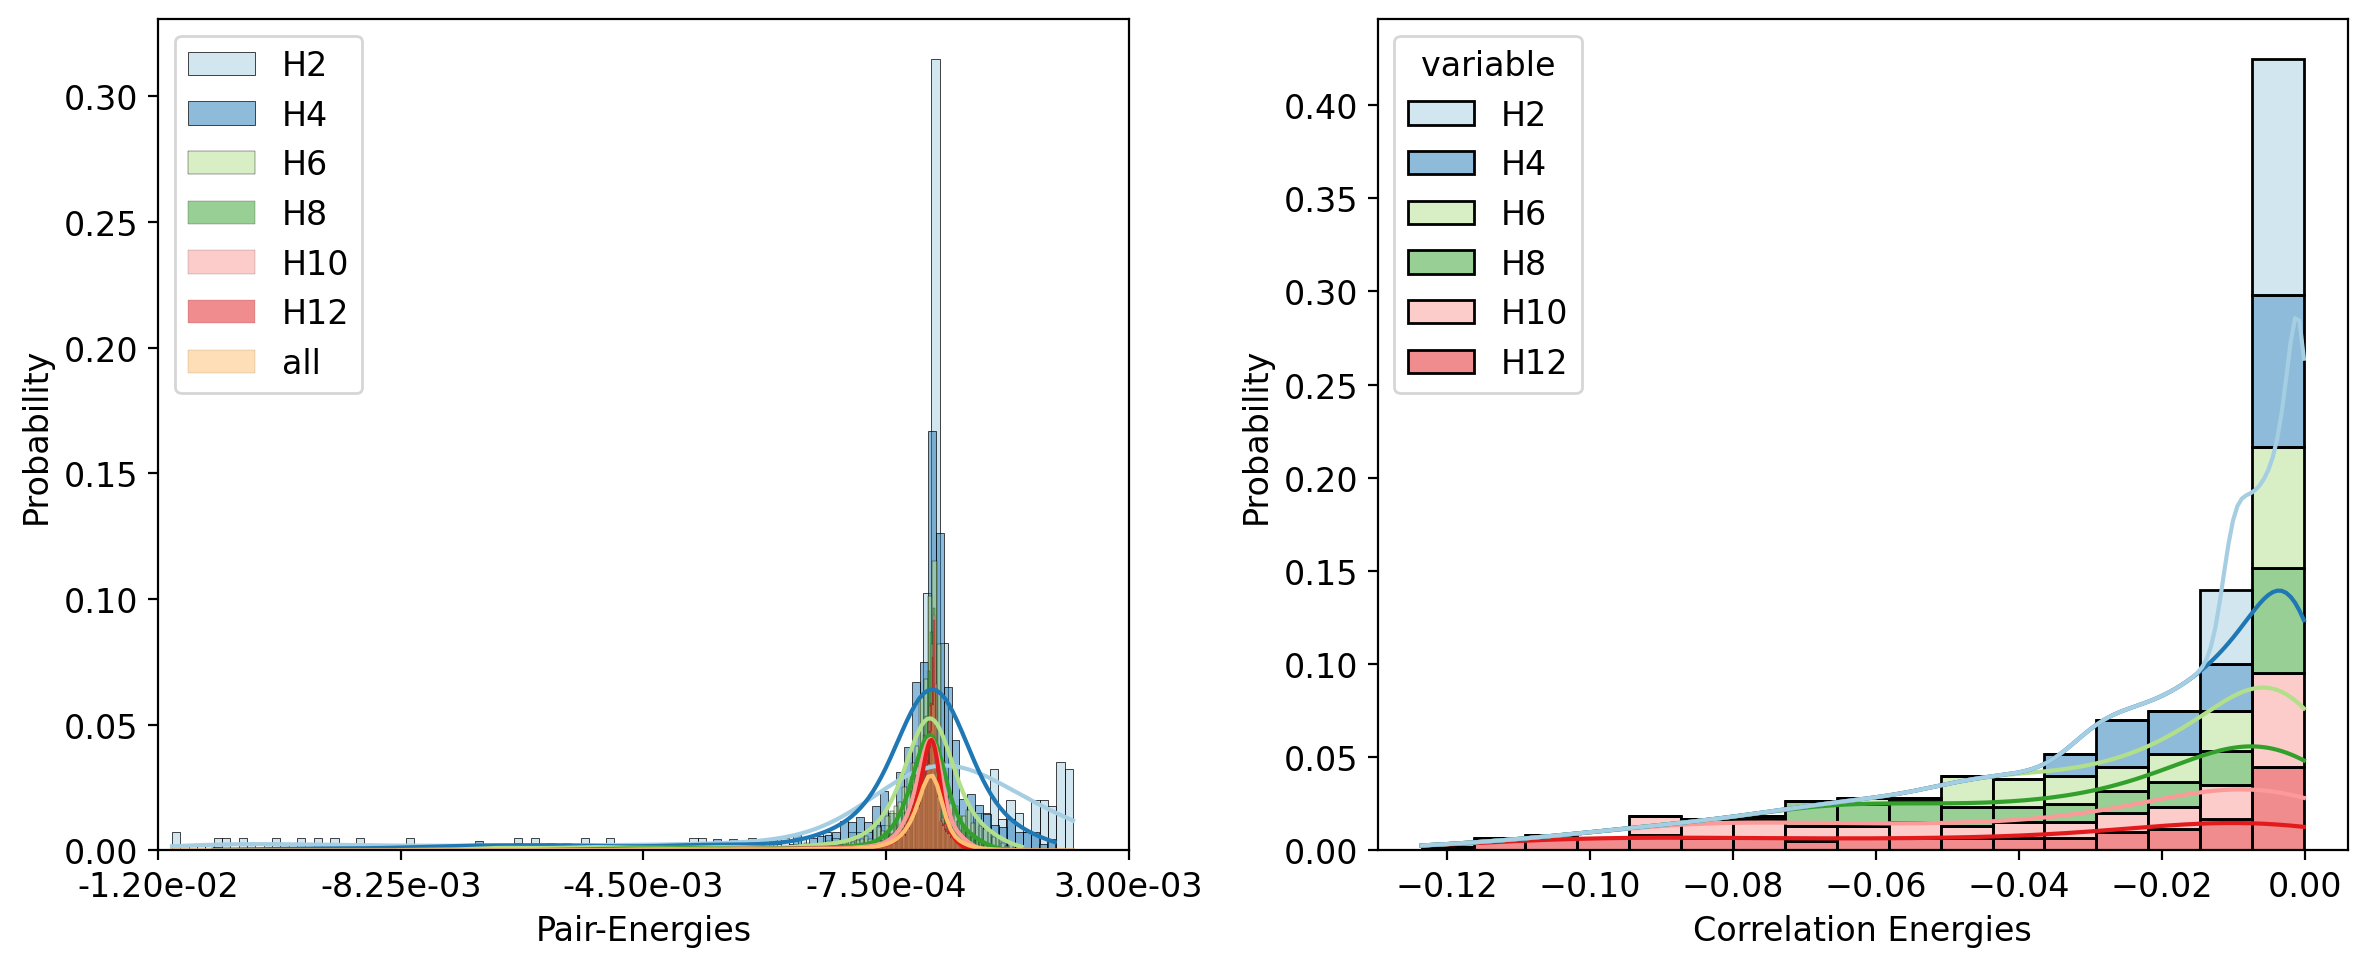

In [16]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5),sharey=False)
for idx,(k,v) in enumerate(testdct.items()):
    sns.histplot(np.hstack([v[0],traindct[k][0]]),label=k,color=pairedcp[idx],kde=True,stat='probability',ax=ax1)

sns.histplot(np.hstack([np.hstack([v[0],traindct[k][0]]) for idx,(k,v) in enumerate(testdct.items())]),label='all',color=pairedcp[idx+1],kde=True,stat='probability',ax=ax1)
ax1.set_xlim(-1.2e-2,3e-3)
ax1.set_xticks(np.linspace(-1.2e-2,3e-3,5))
ax1.set_xticklabels([f'{i:.2e}' for i in np.linspace(-1.2e-2,3e-3,5)])
ax1.legend(loc=2)
ax1.set_xlabel('Pair-Energies')

sns.histplot(data=E2[sorted(E2.columns,key=lambda x: int(x.strip('H')))].melt(),x='value',hue='variable',kde=True,stat='probability',palette=sns.color_palette('Paired'), multiple="stack",ax=ax2)

ax2.set_xlabel('Correlation Energies')
plt.tight_layout()
plt.savefig('images/noCASfeats_dist.png',dpi=300,bbox_inches='tight')
plt.show()

In [17]:
traincorrdict={}
for n in np.arange(2,14,2):
    dat=np.array(recover_train)[np.array(recover_train)[:,0]==f'H{n}']
    corrdf=[]
    for idr,r in enumerate(train_ind):
        chunked=dat[dat[:,1].astype(int)==idr]
        index=chunked[:,2].astype(int)
        dfcorr=pd.DataFrame([y_train[index].sum(),y_pred_train[index].sum()],index=['train','pred'])
        corrdf.append(dfcorr)
    
    df=pd.concat(corrdf,axis=1).T
    df.index=[f'{i:.2f}' for i in train_ind]
    traincorrdict[f'H{n}']=df
    
traincorr_err={}
for k,v in traincorrdict.items():
    traincorr_err[k]=1e3*mean_absolute_error(v['train'],v['pred'])    

In [18]:
testcorrdict={}
for n in np.arange(2,14,2):
    dat=np.array(recover_test)[np.array(recover_test)[:,0]==f'H{n}']
    corrdf=[]
    for idr,r in enumerate(test_ind):
        chunked=dat[dat[:,1].astype(int)==idr]
        index=chunked[:,2].astype(int)
        dfcorr=pd.DataFrame([y_test[index].sum(),y_pred_test[index].sum()],index=['test','pred'])
        corrdf.append(dfcorr)
    
    df=pd.concat(corrdf,axis=1).T
    df.index=[f'{i:.2f}' for i in test_ind]
    testcorrdict[f'H{n}']=df
    
testcorr_err={}
for k,v in testcorrdict.items():
    testcorr_err[k]=1e3*mean_absolute_error(v['test'],v['pred'])    


In [19]:
test_CASPT2=pd.DataFrame.from_dict({k:CASSCF[k].loc[v['pred'].index]+v['pred'] for k,v in testcorrdict.items()},orient='index').T
train_CASPT2=pd.DataFrame.from_dict({k:CASSCF[k].loc[v['pred'].index]+v['pred'] for k,v in traincorrdict.items()},orient='index').T

In [20]:
pairedcp

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

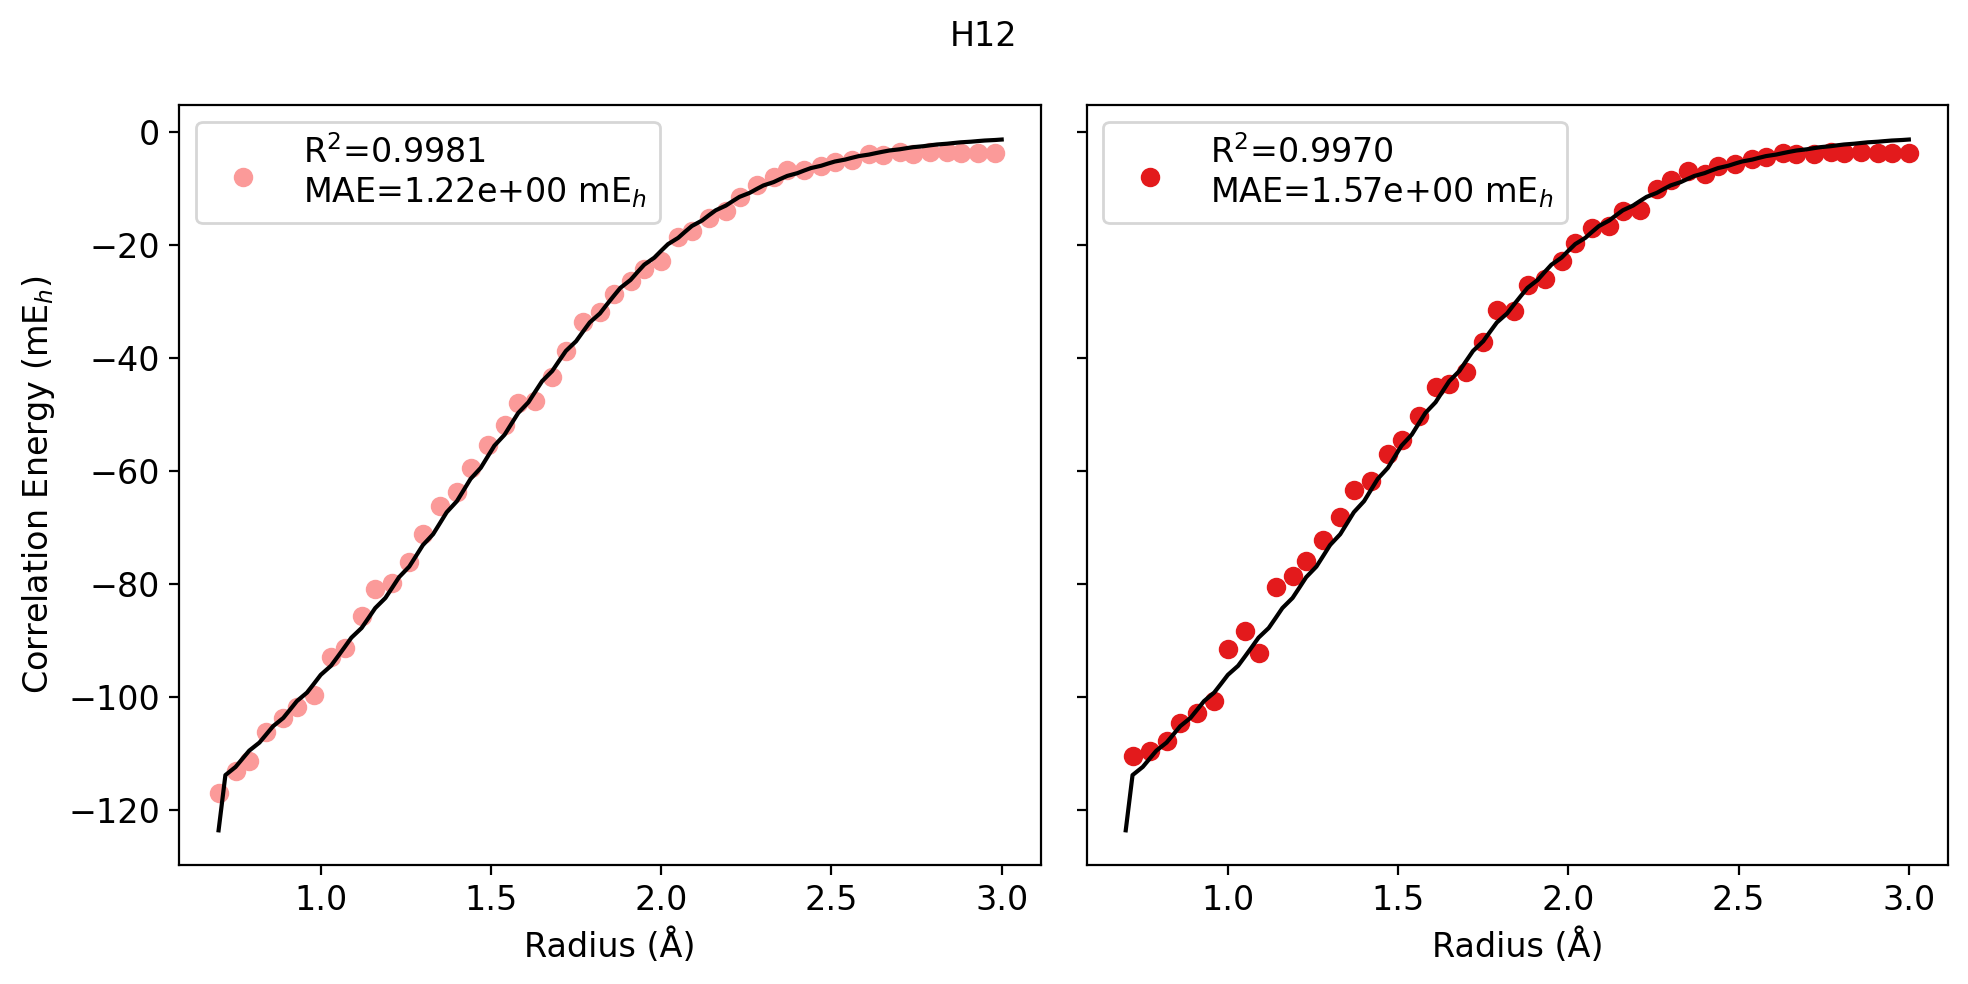

In [21]:
for n in test_CASPT2.columns:
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5),sharey=True)
    train,test=traincorrdict[n],testcorrdict[n]
    true_train,pred_train=train['train'],train['pred']
    true_test,pred_test=test['test'],test['pred']
    
    ax1.scatter(train.index.astype(float),pred_train*1e3,label='R$^{2}$='+f'{r2_score(true_train,pred_train):.4f}\nMAE={1e3*mean_absolute_error(true_train,pred_train):.2e}'+" mE$_{h}$",color=pairedcp[4])
    ax1.plot(E2[n].index.astype(float),E2[n]*1e3,'k')
    ax1.set_xlabel('Radius (Å)')
    ax1.set_ylabel('Correlation Energy (mE$_{h}$)')
    ax1.legend()
    
    ax2.scatter(test.index.astype(float),pred_test*1e3,label='R$^{2}$='+f'{r2_score(true_test,pred_test):.4f}\nMAE={1e3*mean_absolute_error(true_test,pred_test):.2e}'+" mE$_{h}$",color=pairedcp[5])
    ax2.plot(E2[n].index.astype(float),E2[n]*1e3,'k')
    ax2.set_xlabel('Radius (Å)')
    ax2.legend()
    
    fig.suptitle(n)
    
    plt.subplots_adjust(hspace=0,wspace=0)
    plt.tight_layout()
    plt.savefig(f'images/noCASfeats_{n}_E2.png',dpi=300,bbox_inches='tight')
    plt.show()    

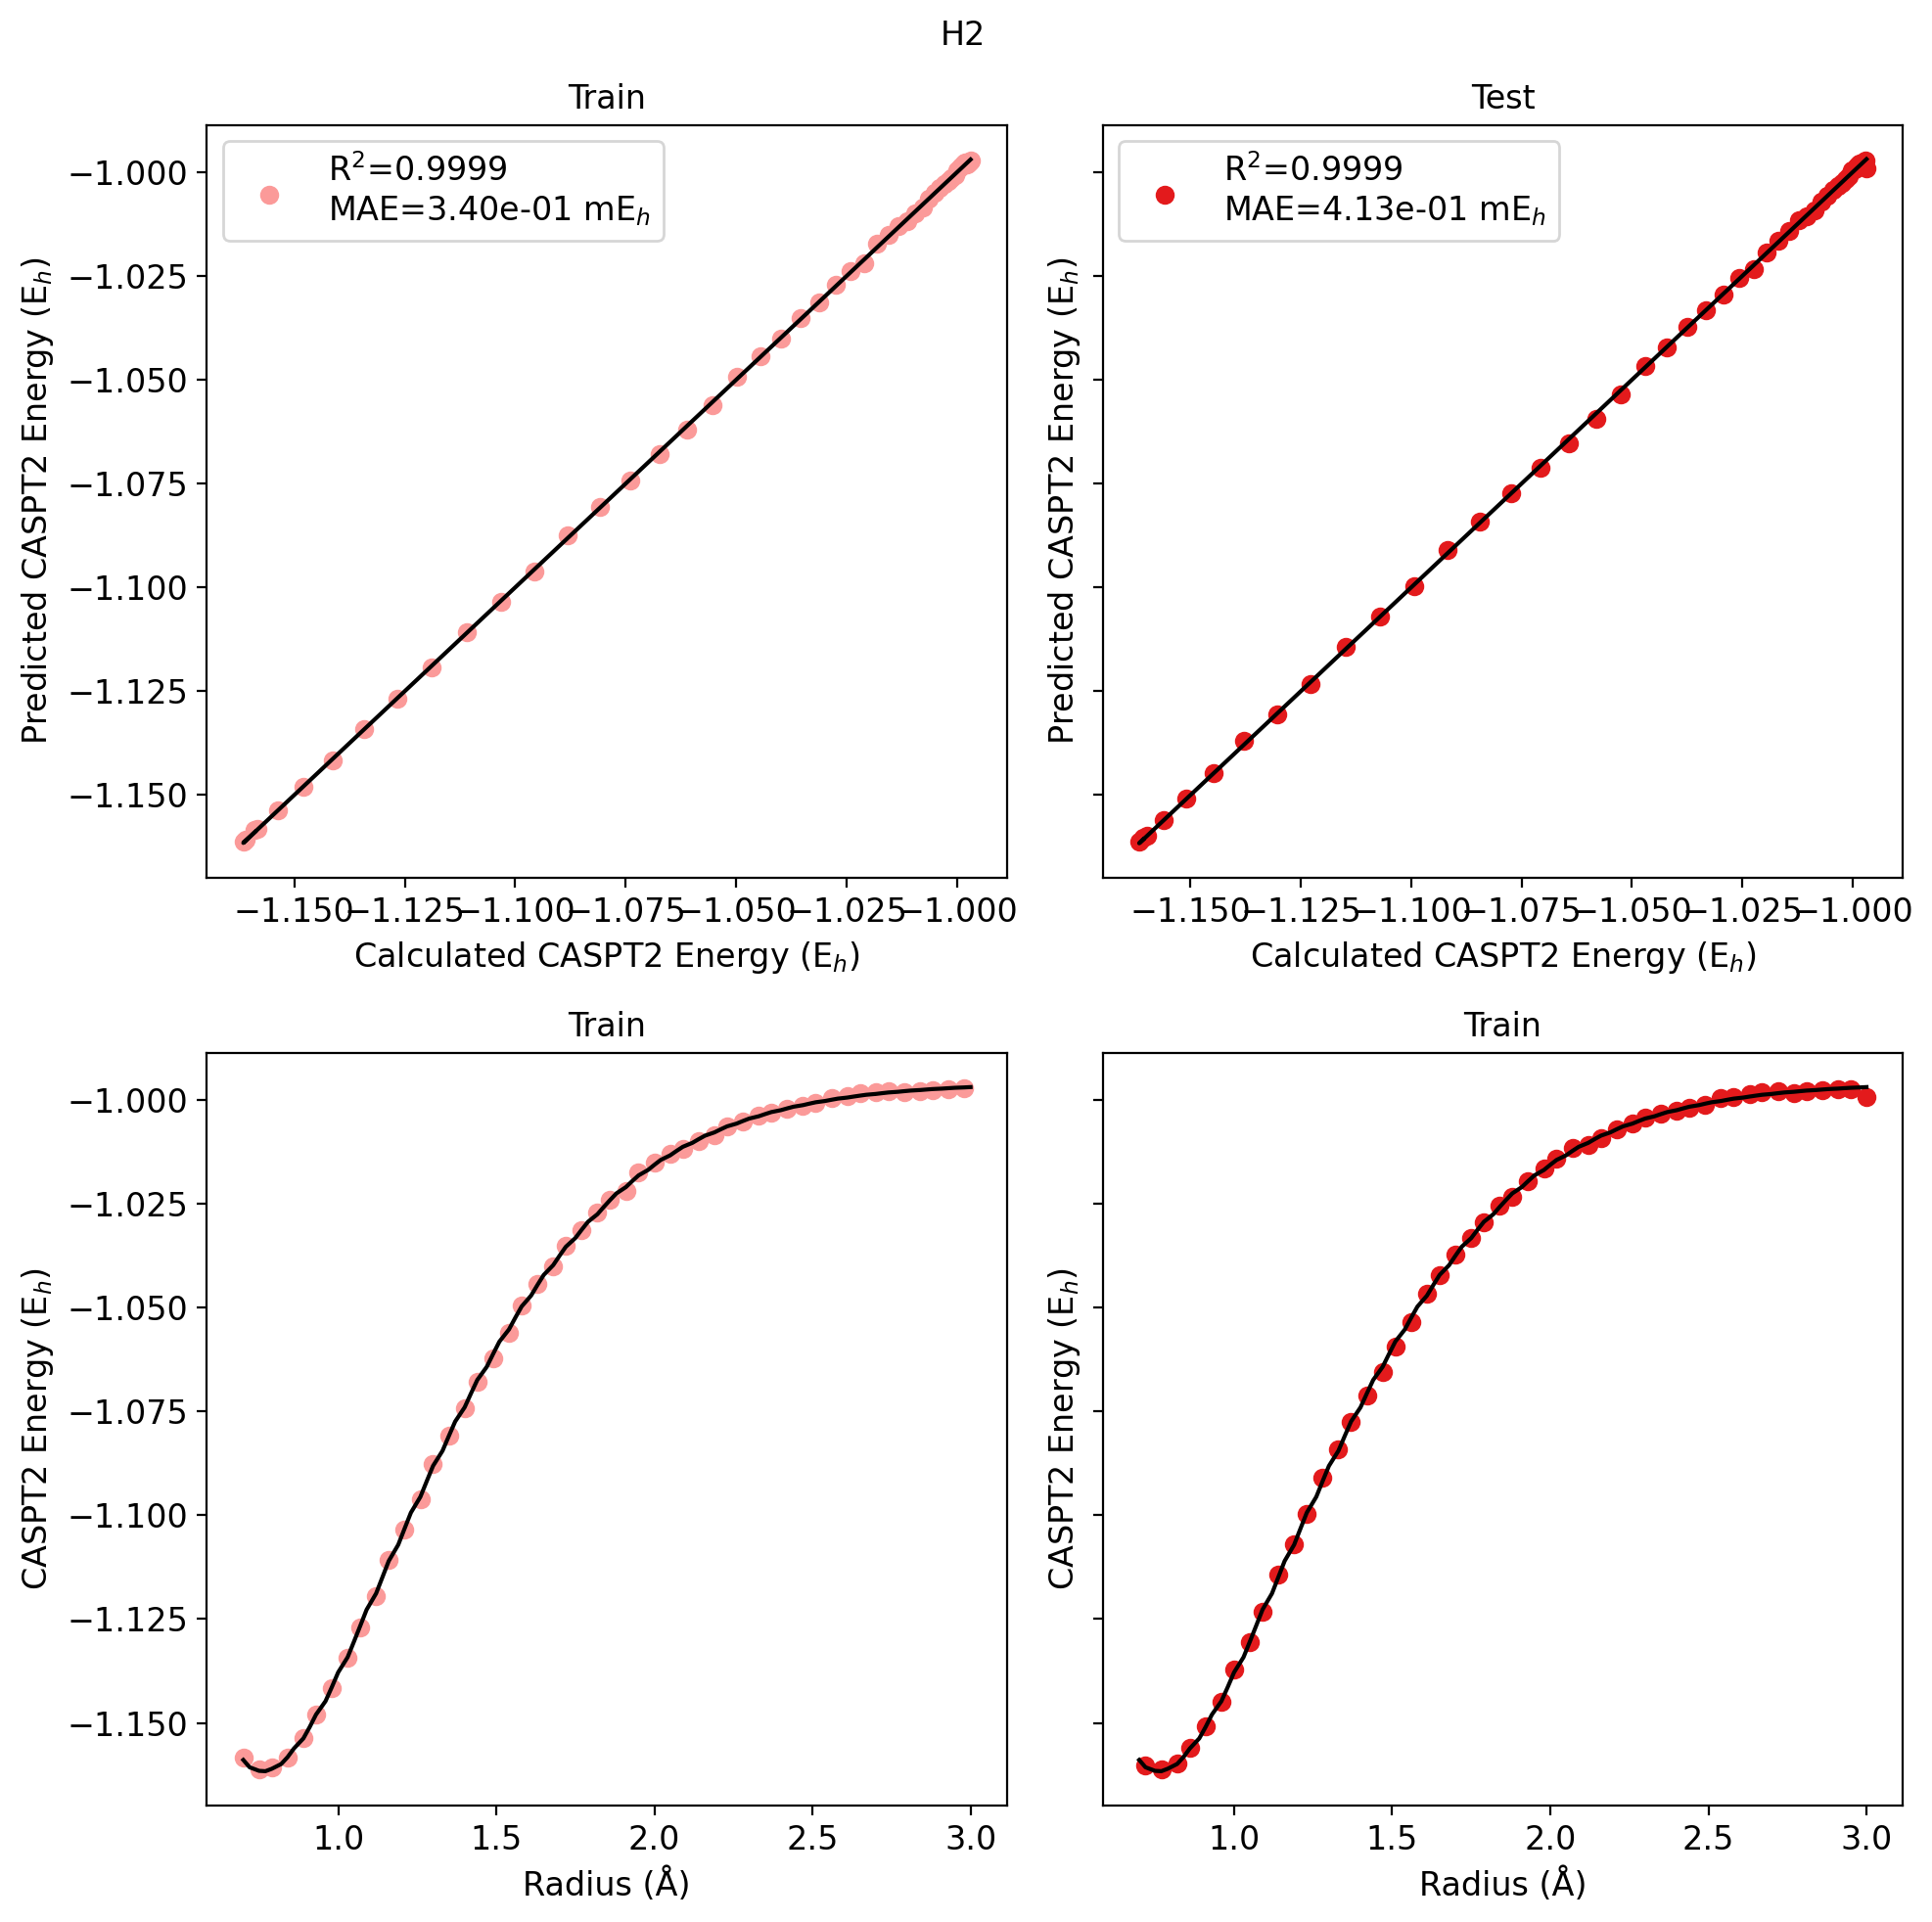

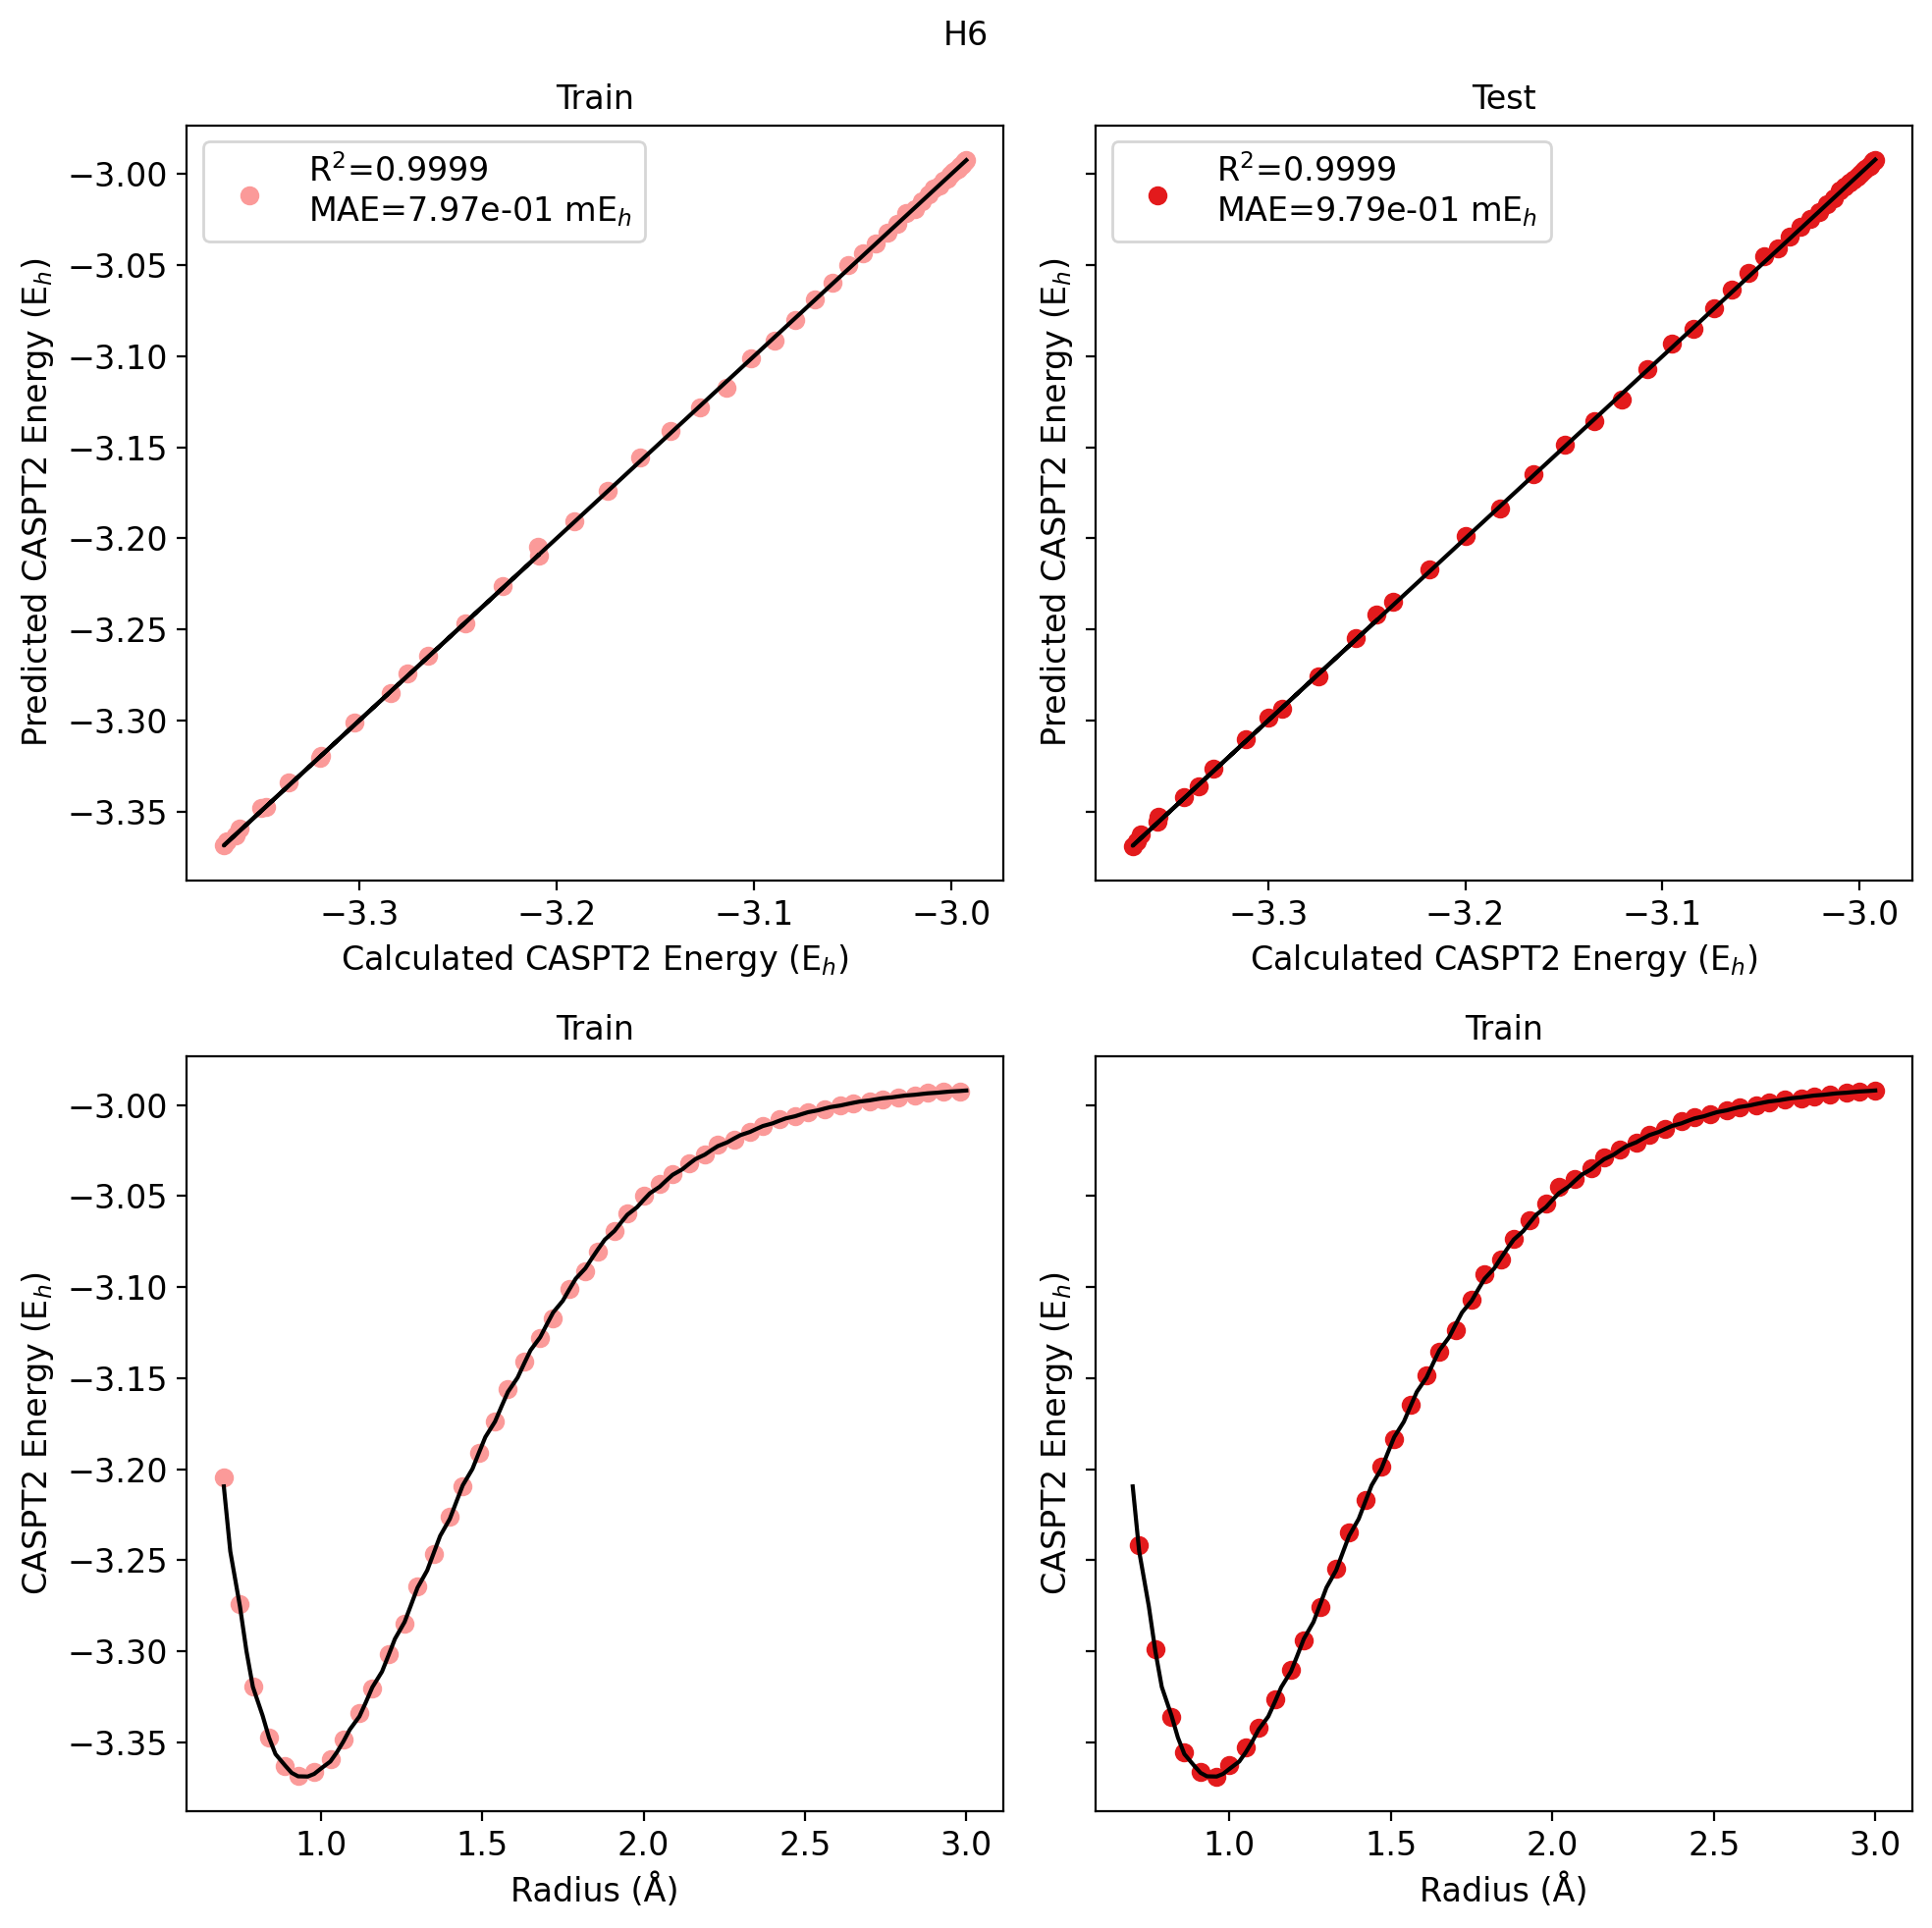

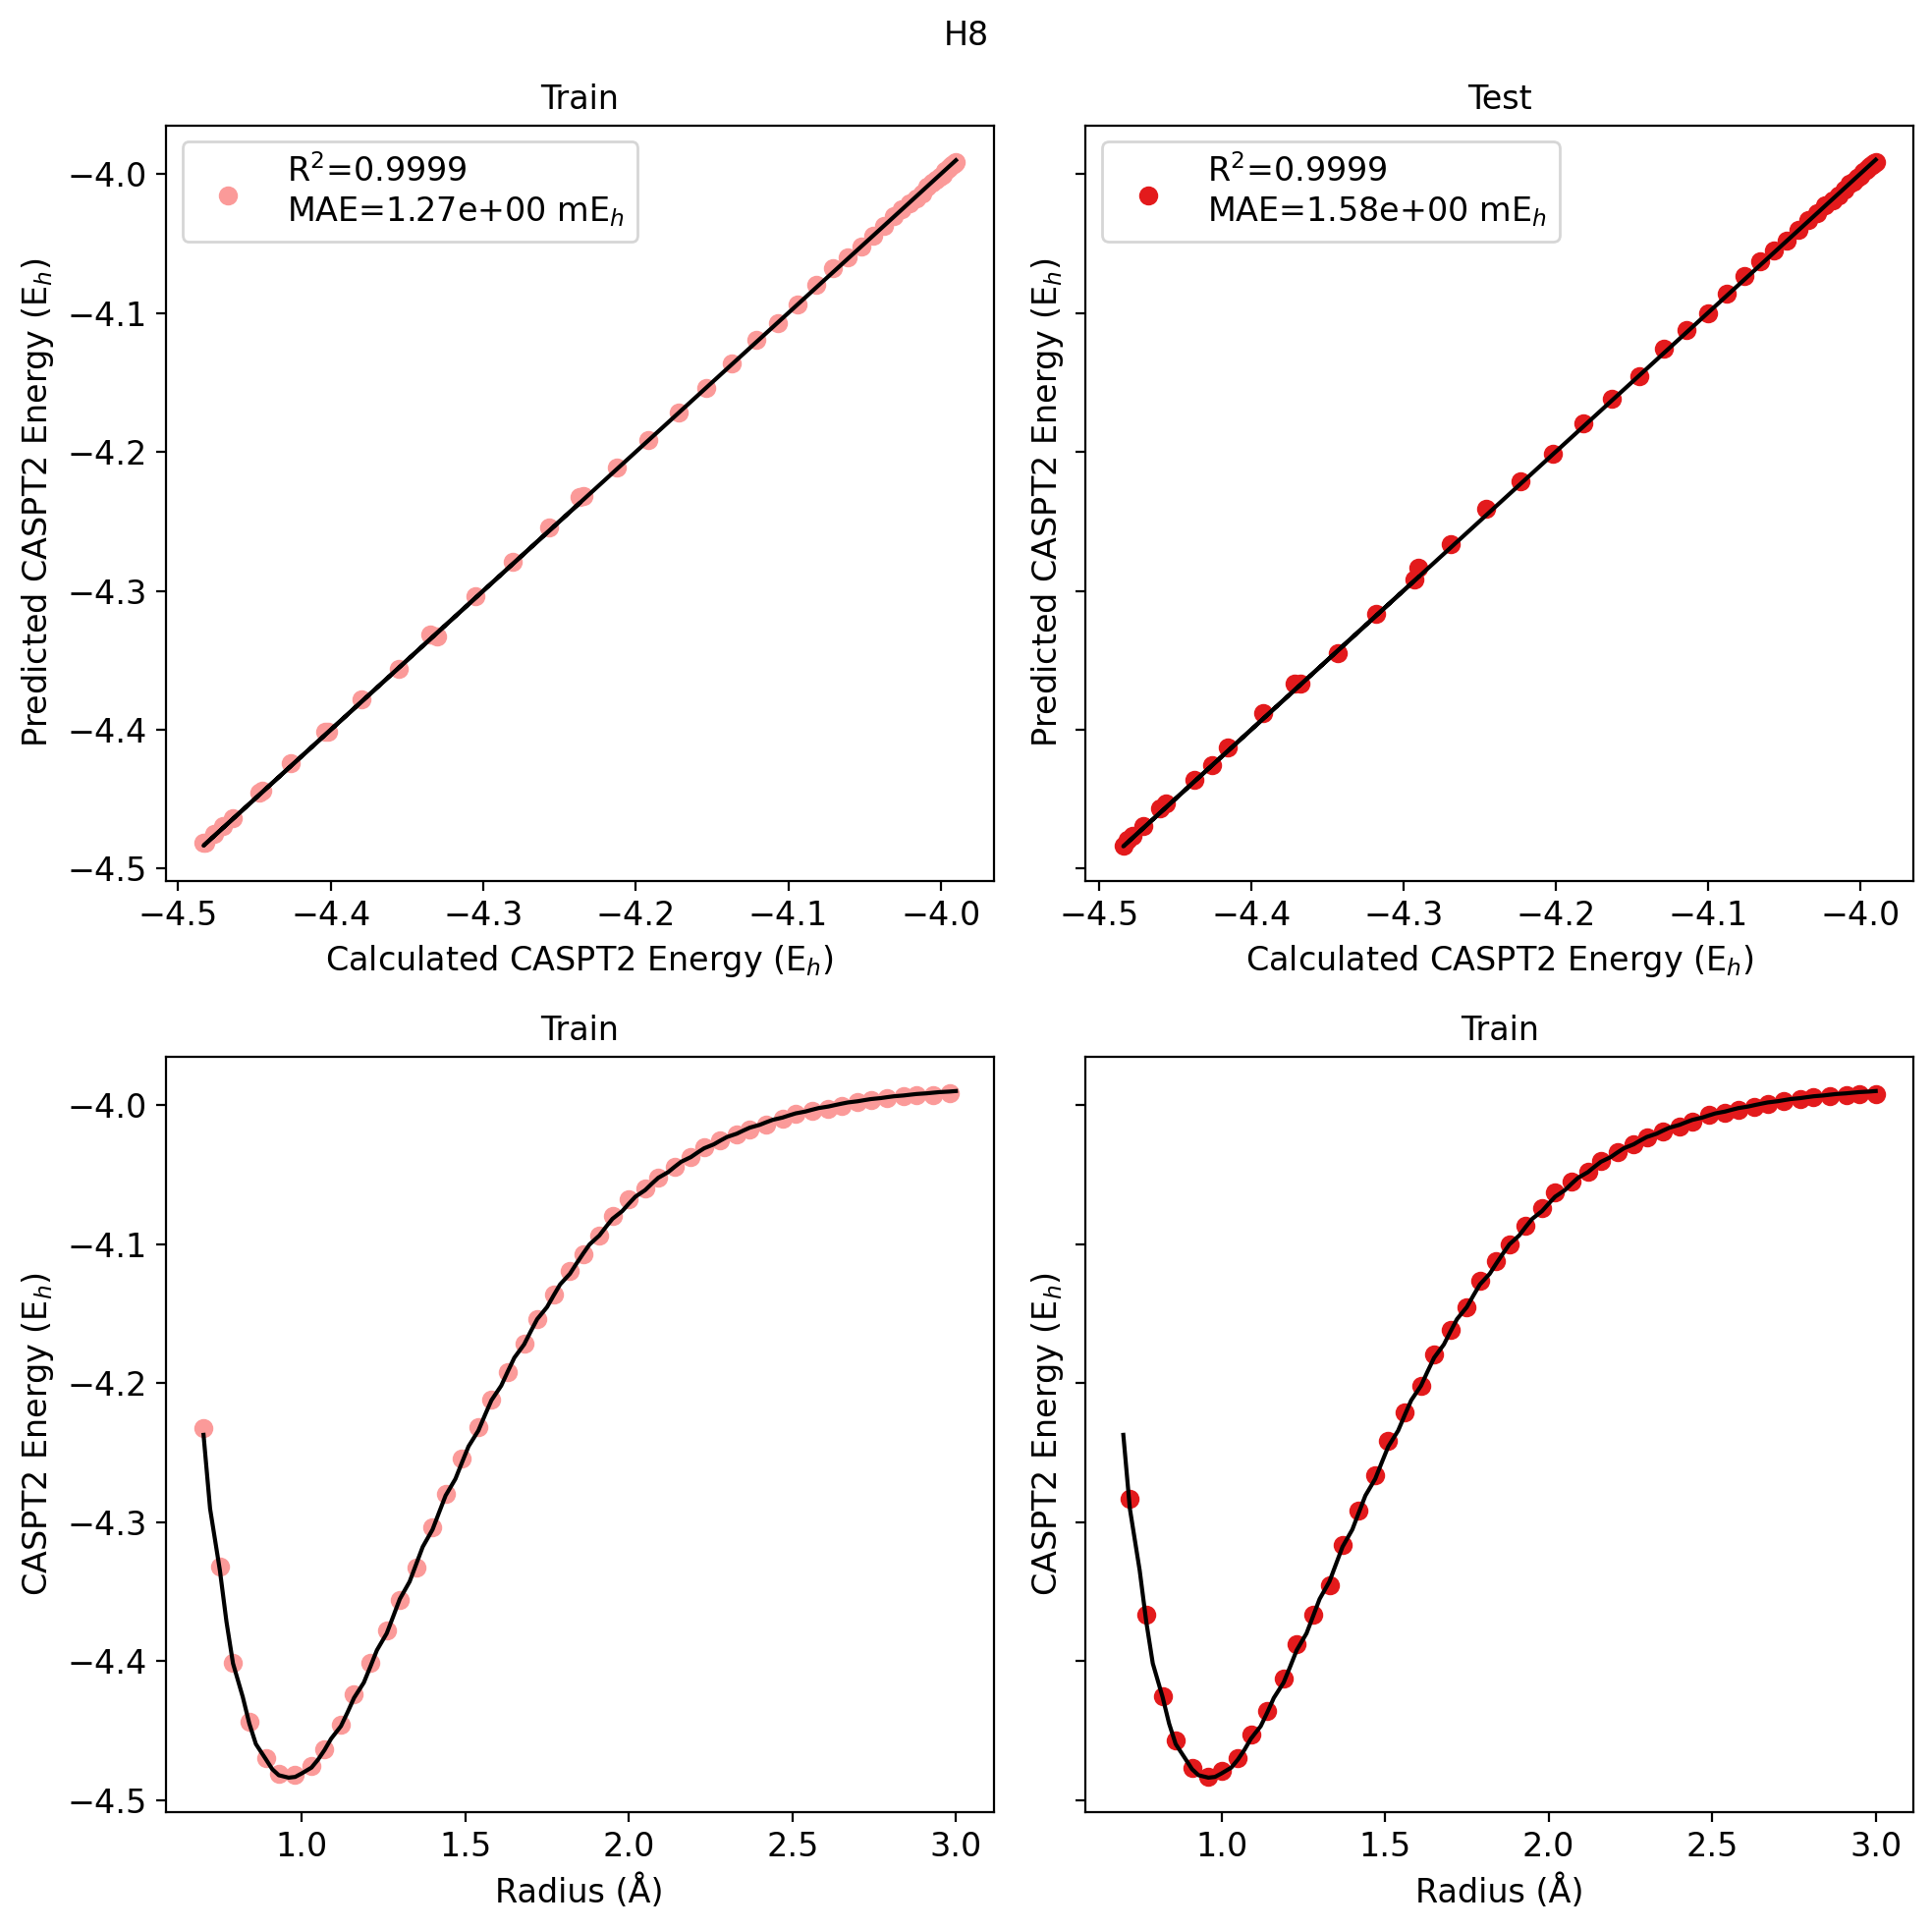

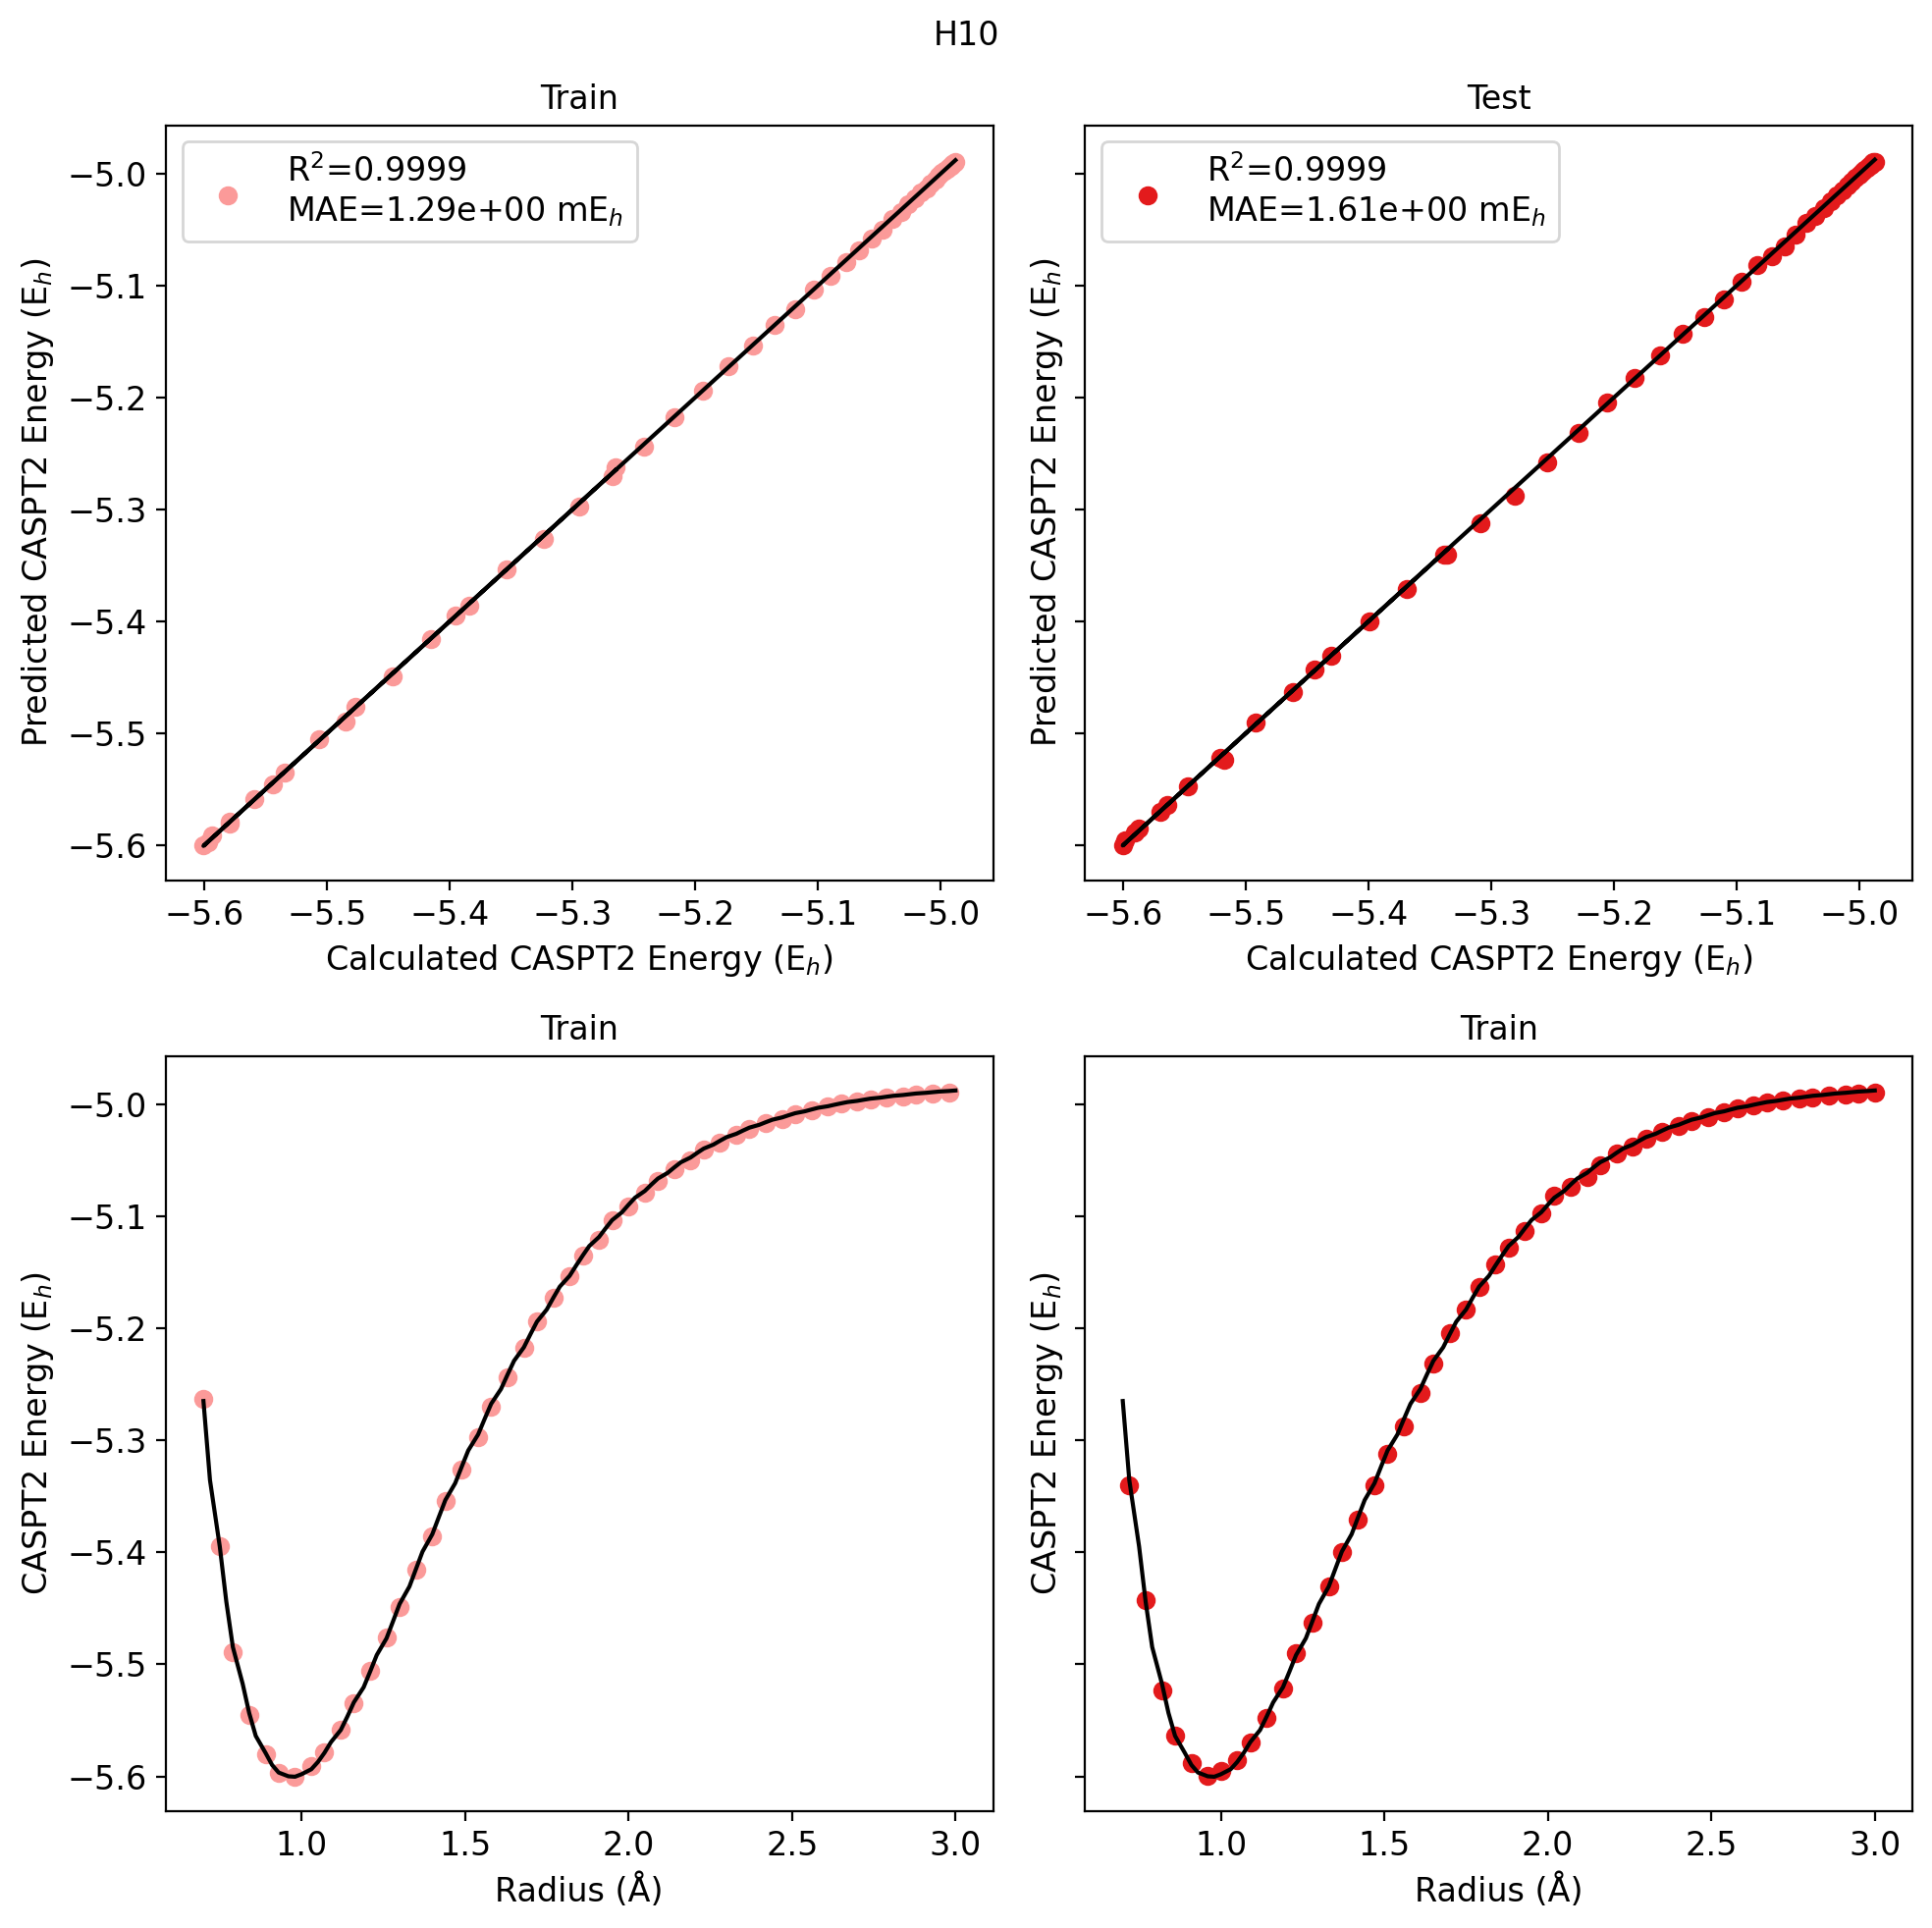

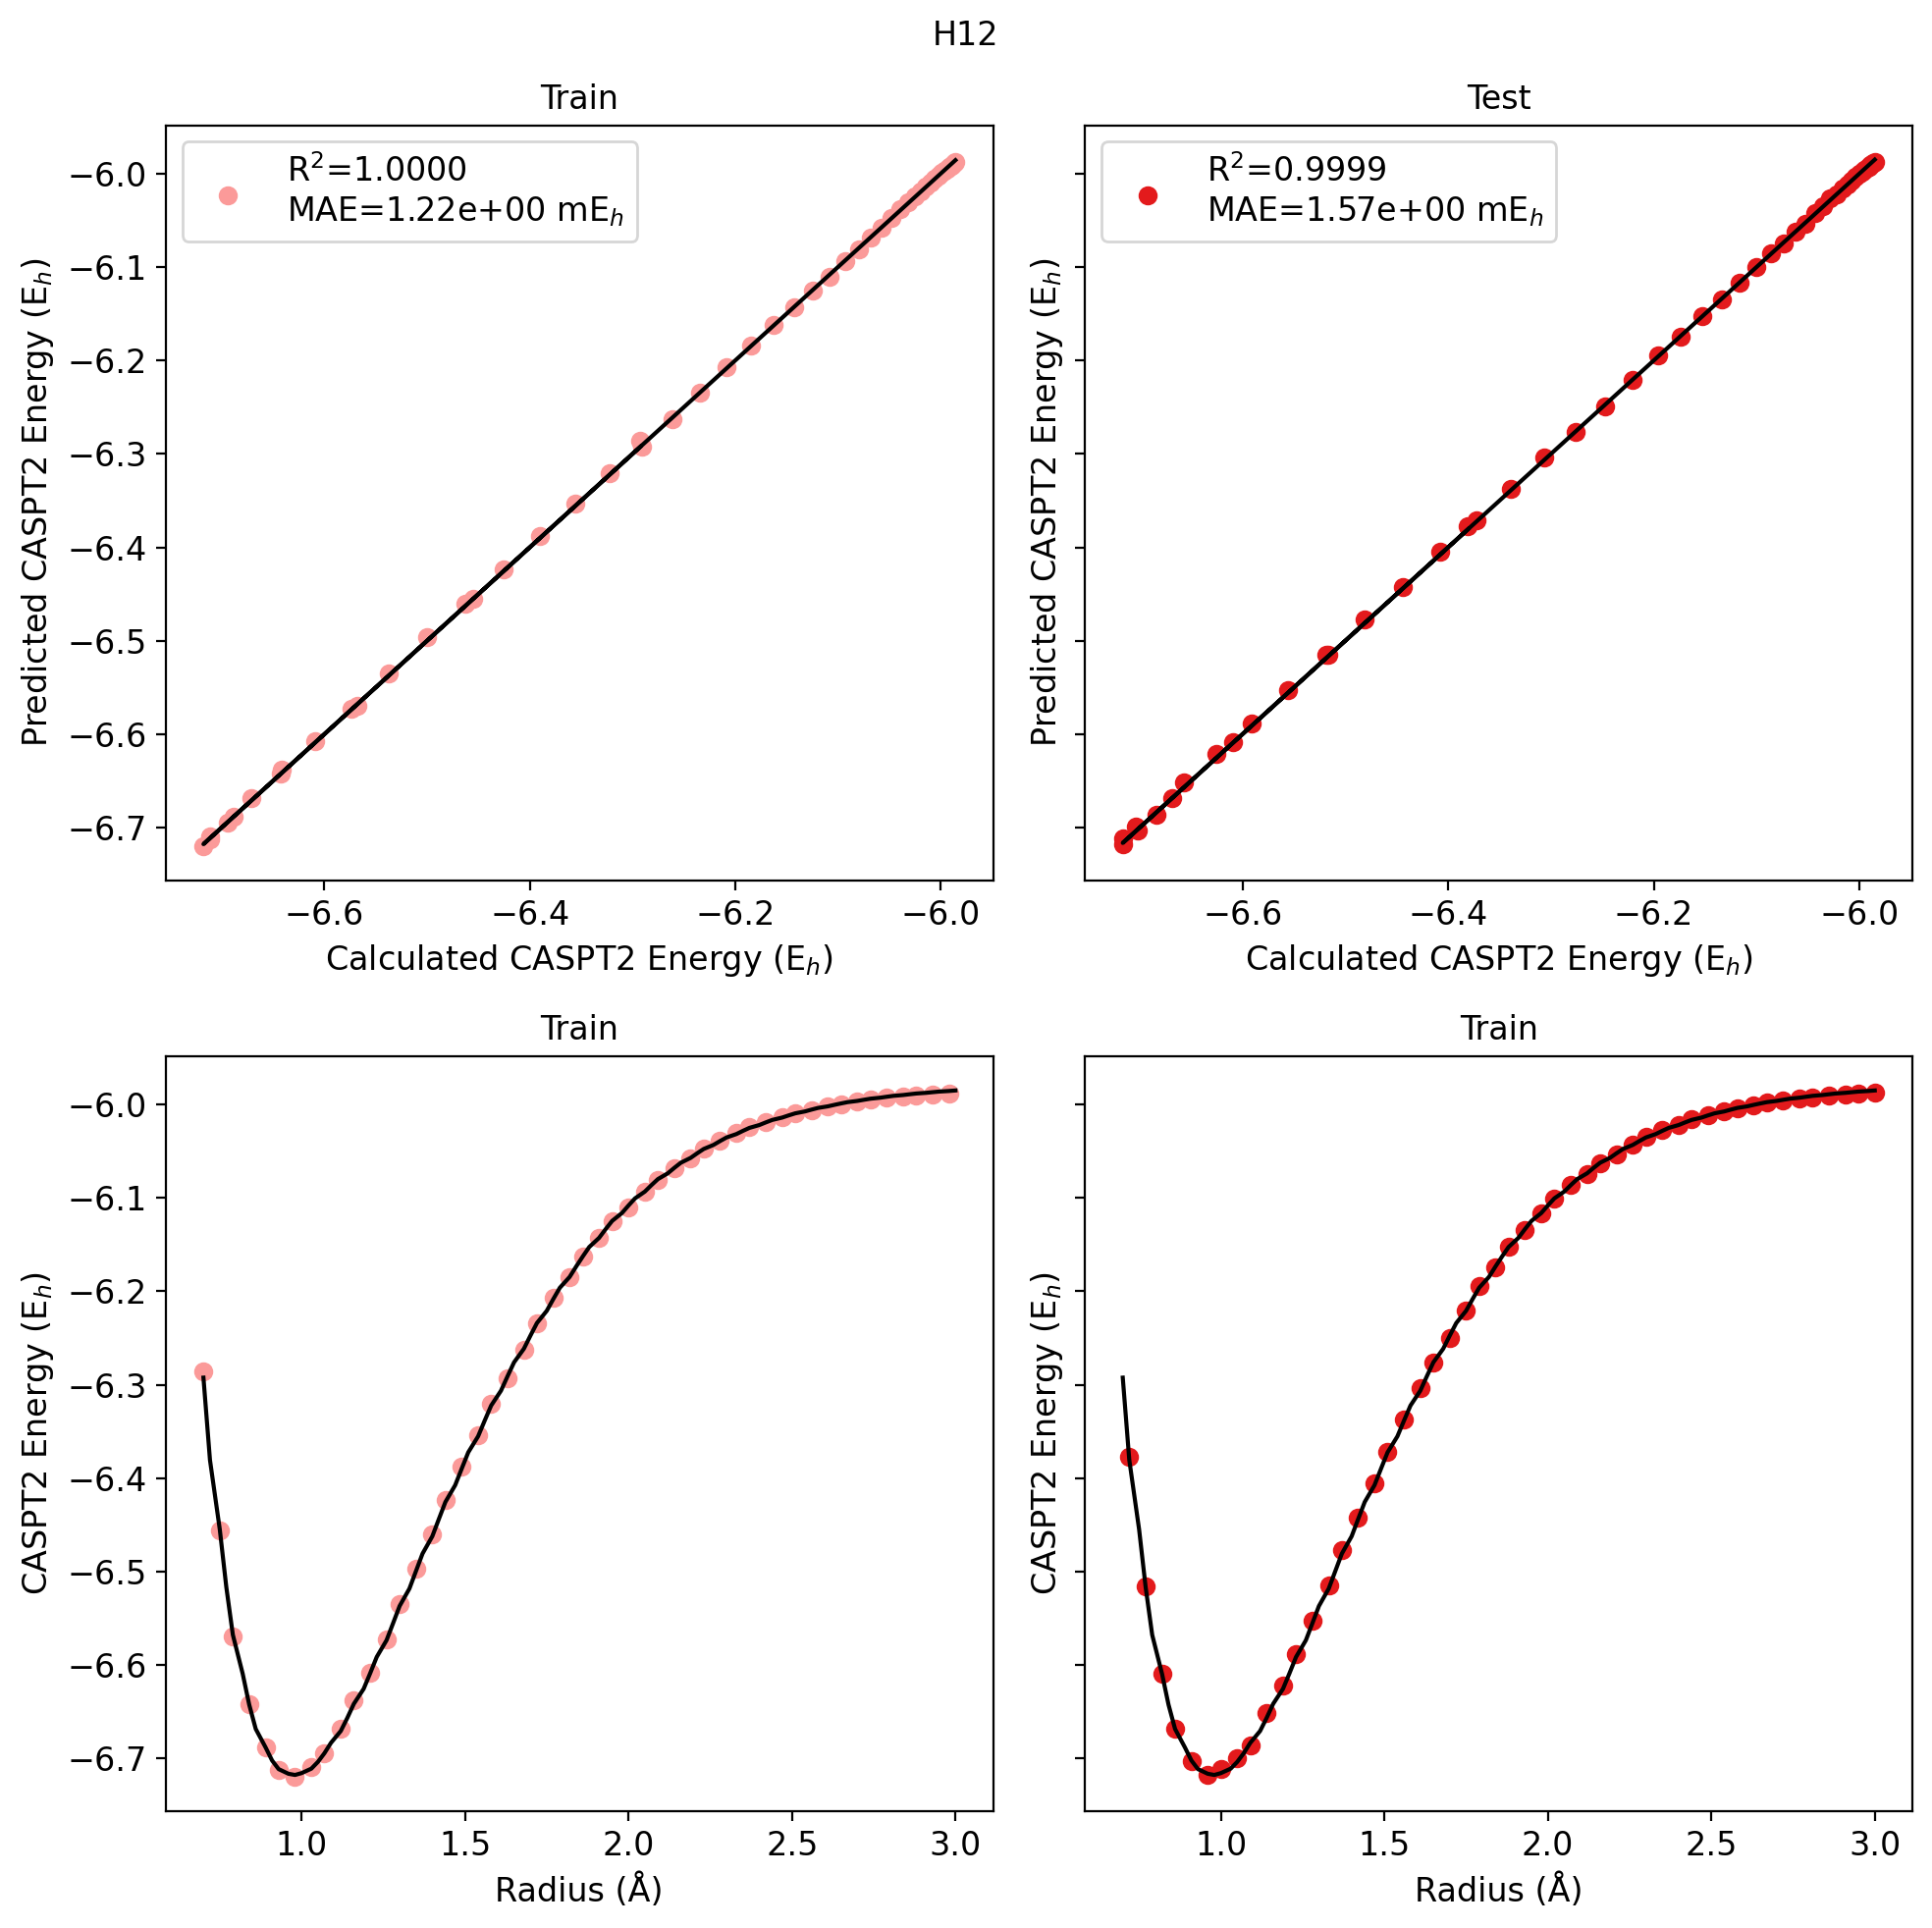

In [22]:
for n in test_CASPT2.columns:
    fig,((ax1,ax2),(ax3,ax4))=plt.subplots(2,2,figsize=(10,10),sharey=True)
    pt2=CASPT2[n]
    true_train,pred_train=pt2.loc[train_CASPT2.index],train_CASPT2[n]
    true_test,pred_test=pt2.loc[test_CASPT2.index],test_CASPT2[n]
    ax1.scatter(true_train,pred_train,label='R$^{2}$='+f'{r2_score(true_train,pred_train):.4f}\nMAE={1e3*mean_absolute_error(true_train,pred_train):.2e}'+" mE$_{h}$",color=pairedcp[4])
    ax1.plot(true_train,true_train,'k')
    ax1.set_xlabel('Calculated CASPT2 Energy (E$_{h}$)')
    ax1.set_ylabel('Predicted CASPT2 Energy (E$_{h}$)')
    ax1.set_title('Train')
    ax1.legend()

    ax2.scatter(true_test,pred_test,label='R$^{2}$='+f'{r2_score(true_test,pred_test):.4f}\nMAE={1e3*mean_absolute_error(true_test,pred_test):.2e}'+" mE$_{h}$",color=pairedcp[5])
    ax2.plot(true_test,true_test,'k')
    ax2.set_xlabel('Calculated CASPT2 Energy (E$_{h}$)')
    ax2.set_ylabel('Predicted CASPT2 Energy (E$_{h}$)')
    ax2.set_title('Test')    
    ax2.legend()
    
    ax3.scatter(np.array(pred_train.index,dtype=float),pred_train,color=pairedcp[4])
    ax3.plot(np.array(pt2.index,dtype=float),pt2.values,'k')
    ax3.set_xlabel('Radius (Å)')
    ax3.set_ylabel('CASPT2 Energy (E$_{h}$)')
    ax3.set_title('Train')
    
    ax4.scatter(np.array(pred_test.index,dtype=float),pred_test,color=pairedcp[5])
    ax4.plot(np.array(pt2.index,dtype=float),pt2.values,'k')
    ax4.set_xlabel('Radius (Å)')
    ax4.set_ylabel('CASPT2 Energy (E$_{h}$)')
    ax4.set_title('Train')
    
    fig.suptitle(n)
    
    plt.subplots_adjust(wspace=0.05)
    plt.tight_layout()
    plt.savefig(f'images/noCASfeats_{n}_CASPT2.png',dpi=300,bbox_inches='tight')
    plt.show()

In [23]:
testdfcorr=pd.DataFrame.from_dict(testcorr_err,orient='index').rename(columns={0:'test'})
traindfcorr=pd.DataFrame.from_dict(traincorr_err,orient='index').rename(columns={0:'train'})
errormeltcorr=pd.concat([traindfcorr,testdfcorr],axis=1).reset_index().melt(id_vars='index')
errormeltcorr['index']=[i.split('_')[0] for i in errormeltcorr['index']]

In [24]:
dev=pd.concat([CASPT2[i]-CASSCF[i] for i in sorted(CASSCF.columns,key=lambda x: int(x.strip('H')))],axis=1)

In [25]:
errormelt

index variable     value
0     H2    train  0.177154
1     H4    train  0.247077
2     H6    train  0.223368
3     H8    train  0.168777
4    H10    train  0.162898
5    H12    train  0.143876
6     H2     test  0.200077
7     H4     test  0.321572
8     H6     test  0.255828
9     H8     test  0.191221
10   H10     test  0.177436
11   H12     test  0.154742

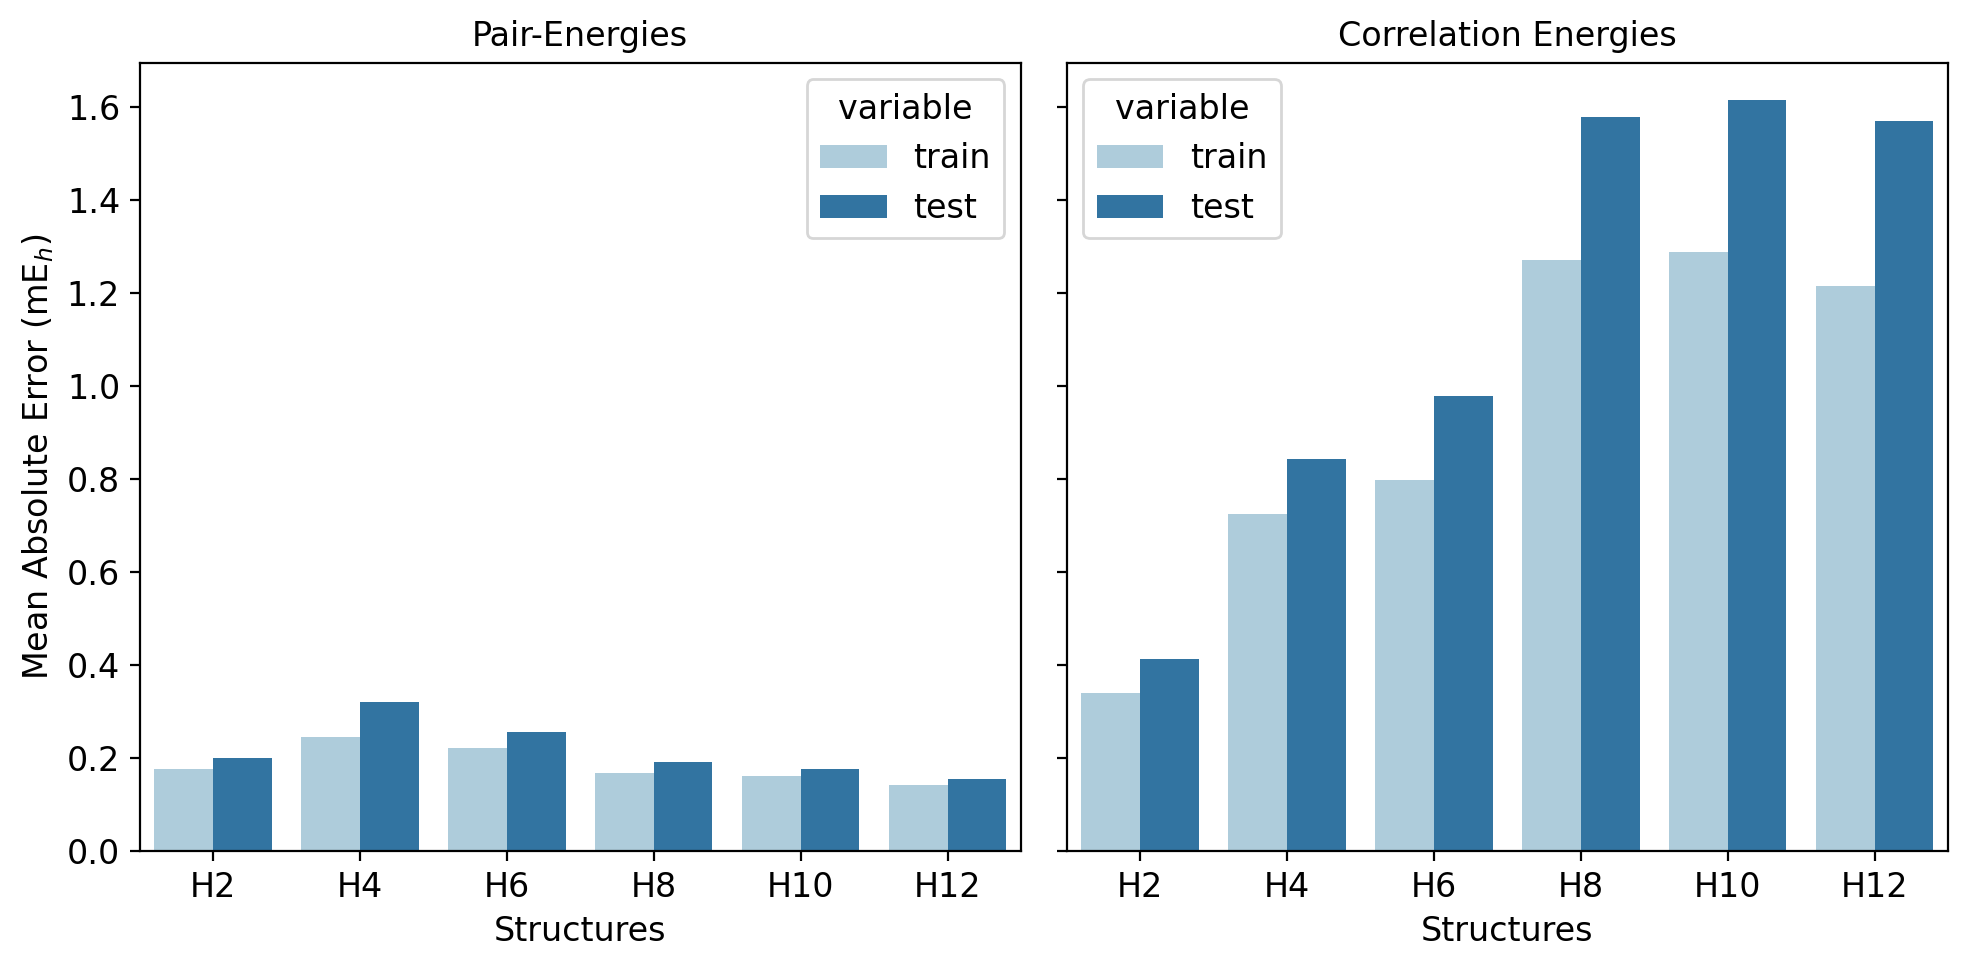

In [26]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5),sharey=True)

sns.barplot(data=errormelt,x='index',y='value',hue='variable',palette=sns.color_palette('Paired'),ax=ax1)
ax1.set_ylabel('Mean Absolute Error (mE$_{h}$)')
ax1.set_xlabel('Structures')
ax1.set_title('Pair-Energies')

sns.barplot(data=errormeltcorr,x='index',y='value',hue='variable',palette=sns.color_palette('Paired'),ax=ax2)
# ax2.set_ylabel('Mean Absolute Error (mE$_{h}$)')
ax2.set_ylabel('')
ax2.set_xlabel('Structures')
ax2.set_title('Correlation Energies')

plt.tight_layout()
plt.savefig('images/noCASfeats_MAE_bar.png',dpi=300,bbox_inches='tight')
plt.show()

In [27]:
# # SHAP
# feat_name=['screen1_1', 'screen1_2', 'screen1_3', 'screen1_4', 'screen2_1','screen2_2', 'screen2_3', 'screen2_4', 'eijab_1', 'eijab_2','eijab_3', 'eijab_4', 'screenvirt_1', 'screenvirt_3','screenvirt_4', 'Fr1', 'Fr2', 'Fr3', 'Fr4', 'Fs2', 'Fs3', 'Fs4','occs1', 'occs3', 'SCFFr1', 'SCFFr2', 'SCFFr3', 'SCFFr4', 'SCFFs1','SCFFs2', 'SCFFs3', 'SCFFs4', 'hrr1', 'hrr2', 'hrr3', 'hrr4','hss1', 'hss2', 'hss3', 'hpp', 'Fp', 'Fq', 'occp', 'occq']
# import shap
# explainer = shap.Explainer(model.predict, X_test)
# shap_values = explainer(X_test)
# dffeat=pd.DataFrame(shap_values.abs.values.mean(axis=0),index=feat_name,columns=['shap']).reset_index().rename(columns={'index':'feat'})

# plt.figure(figsize=(8,10))
# color_map=sns.color_palette('rocket',6)
# fontsize = 18
# ax=dffeat.sort_values('shap').plot.barh(x='feat',y='shap',figsize=(9,10),legend=False,color=color_map[3])
# ax.bar_label(ax.containers[0], fmt='%.4e',fontsize=12,padding=1)
# plt.xticks(np.linspace(0,6e-3,4))
# plt.xlim(0,6e-3)
# plt.xlabel('mean(|SHAP value|)',fontsize=fontsize)
# plt.ylabel('Features',fontsize=fontsize)
# plt.tight_layout()
# plt.savefig('images/noCASfeats_shap_bar.png',dpi=300, bbox_inches='tight')
# plt.show()

In [28]:
# pd.DataFrame(feat_name).to_excel('kept_feat.xlsx')